<div align="center"><h1> Projet Data Science </h1></div>
<div align="center"><h2> Classification d'assertions selon leur valeurs de véracité ( automatic fact-checking ) </h2></div>

<div class="alert alert-block alert-info" align="center">
    <h1>
        Imports
    </h1>
</div>

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from enum import Enum

<div class="alert alert-block alert-info" align="center">
    <h1>
        Loading the dataset
    </h1>
</div>

In [2]:
labels = ["ID", "ClaimReviewAuthor", "ClaimReviewAuthorName", "ClaimReviewAuthorURL",
          "ClaimReviewClaimReviewed", "ClaimReviewDatePublished", "ClaimReviewSource", "ClaimReviewURL",
          "CreativeWorkAuthorName", "CreativeWorkAuthorSameAs", "CreativeWorkDatePublished", "ExtraBody",
          "ExtraEntitiesAuthor", "ExtraEntitiesBody", "ExtraEntitiesClaimReviewClaimReviewed", "ExtraEntitiesKeywords",
          "ExtraReferedLinks", "ExtraTags", "ExtraTitle", "RatingAlternateName",
          "RatingBestRating", "RatingRatingValue", "RatingWorstRating"]

labelsClaimsKG = ["ID", "Text", "Date", "TruthRating", "RatingName", "Author", "Headline",
                  "NamedEntitiesClaim", "NamedEntitiesArticle", "Keywords", "Source", "SourceURL", "Link", "Language"]

df = pd.read_csv('datasets/ClaimsKG.csv', sep = ',', names = labelsClaimsKG, skiprows = 1)

<div class="alert alert-block alert-info" align="center">
    <h1>
        Printing informations
    </h1>
</div>

## Shape

In [3]:
print(f'Shape :\n{df.shape}')

Shape :
(10000, 14)


## Informations

In [4]:
print(f'Informations :')
df.info()

Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
ID                      10000 non-null object
Text                    10000 non-null object
Date                    10000 non-null object
TruthRating             10000 non-null int64
RatingName              10000 non-null object
Author                  10000 non-null object
Headline                9882 non-null object
NamedEntitiesClaim      9864 non-null object
NamedEntitiesArticle    6497 non-null object
Keywords                8691 non-null object
Source                  10000 non-null object
SourceURL               10000 non-null object
Link                    10000 non-null object
Language                10000 non-null object
dtypes: int64(1), object(13)
memory usage: 1.1+ MB


## Description

In [5]:
print(f'Description :')
display(df.describe())

Description :


,TruthRating
count,10000.000000
mean,1.237900
std,1.226154
min,-1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


## Printing some lines

In [6]:
print(f'Printing some lines :')
display(df.sample(5))

Printing some lines :


,ID,Text,Date,TruthRating,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source,SourceURL,Link,Language
3360,http://data.gesis.org/claimskg/claim_review/22...,A photograph shows an obese tiger.,Unknown,1,FALSE,Unknown,Fat Cat,"Photoshop contest,Reddit,Worth1000.com,fat tig...",NaN,animals,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/obese-tiger-...,English
3001,http://data.gesis.org/claimskg/claim_review/e4...,'The Constitution doesn't allow the governor t...,2011-02-16,2,MIXTURE,J.D. Alexander,Senator makes point about Rick Scott’s authori...,"Barack Obama,Bill Nelson,Charlie Crist,Dan Gel...",NaN,"Ethics,State Budget,Transportation",politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English
2541,http://data.gesis.org/claimskg/claim_review/15...,Photograph shows a surfer’s close encounter wi...,Unknown,-1,OTHER,Unknown,Shark Surfin’,Surfrider Beach,NaN,"animals, ASP Article",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/shark-surfin/,English
3817,http://data.gesis.org/claimskg/claim_review/f6...,From Obama's book: 'I found a solace in nursin...,2008-05-19,1,FALSE,Chain email,Obama didn't write that,"Barack Obama,Dreams from My Father,Hawaii,Hold...",NaN,Candidate Biography,politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
4949,http://data.gesis.org/claimskg/claim_review/f6...,"A photo of the Kumbh Mela, a Hindu festival in...",2019-01-17,-1,OTHER,multiple sources,"No, this is not a photo of the Kumbh Mela, a H...","Allahabad,BJP,Bharatiya Janata Party,Facebook,...","Hindu,India,Kumbh Mela,north India",NaN,factcheck_afp,https://factcheck.afp.com/,https://factcheck.afp.com//no-not-photo-kumbh-...,English


## Affichage d'informations sur toutes les colonnes

In [7]:
for column in df.columns:
      print(f'Nombre de valeurs nulles pour {column} :\n{df[column].isnull().value_counts()}\n')

Nombre de valeurs nulles pour ID :
False    10000
Name: ID, dtype: int64

Nombre de valeurs nulles pour Text :
False    10000
Name: Text, dtype: int64

Nombre de valeurs nulles pour Date :
False    10000
Name: Date, dtype: int64

Nombre de valeurs nulles pour TruthRating :
False    10000
Name: TruthRating, dtype: int64

Nombre de valeurs nulles pour RatingName :
False    10000
Name: RatingName, dtype: int64

Nombre de valeurs nulles pour Author :
False    10000
Name: Author, dtype: int64

Nombre de valeurs nulles pour Headline :
False    9882
True      118
Name: Headline, dtype: int64

Nombre de valeurs nulles pour NamedEntitiesClaim :
False    9864
True      136
Name: NamedEntitiesClaim, dtype: int64

Nombre de valeurs nulles pour NamedEntitiesArticle :
False    6497
True     3503
Name: NamedEntitiesArticle, dtype: int64

Nombre de valeurs nulles pour Keywords :
False    8691
True     1309
Name: Keywords, dtype: int64

Nombre de valeurs nulles pour Source :
False    10000
Name: Source

## Affichage des colonnes vides

In [8]:
array = []
for column in df.columns:
    value = False
    value = df[column].isnull().any()
    if value:
        array.append(column)
print(f'Nombre de colonnes vides : {len(array)}\nLes colonnes vide sont :\n{array}')

Nombre de colonnes vides : 4
Les colonnes vide sont :
['Headline', 'NamedEntitiesClaim', 'NamedEntitiesArticle', 'Keywords']


## Get a series of unique values in each column of the dataframe

In [9]:
for column in df.columns:
    uniqueValues = df[column].unique()
    print(f'Number of unique elements in column {column} : {len(uniqueValues)}, values & type :\n{uniqueValues}\n')

Number of unique elements in column ID : 9944, values & type :
['http://data.gesis.org/claimskg/claim_review/becd1657-d104-5a3e-94de-61f26b8e3f6e'
 'http://data.gesis.org/claimskg/claim_review/8a8a0f17-b1ec-5f86-8ad4-4bb0f1dd5cf5'
 'http://data.gesis.org/claimskg/claim_review/c215a999-c7cf-5c9f-bada-bcddfccd9a56'
 ...
 'http://data.gesis.org/claimskg/claim_review/0e921f02-25e3-5ec7-873d-dfefae8e0cb1'
 'http://data.gesis.org/claimskg/claim_review/c94a3d9f-9758-5b90-8211-c381cbadcef8'
 'http://data.gesis.org/claimskg/claim_review/d1e3a15c-9bcb-5026-97c1-dc5b14c8c16d']

Number of unique elements in column Text : 9977, values & type :
['Malia Obama cashed a $1.2 million tax refund check.'
 'High diver is saved from jumping into a drained pool when he casts a cross-like shadow on the wall.'
 "'And the revenue generated by drilling off Virginia’s coast? $40 million over 10 years.'"
 ...
 "'Trump Management was charged with discriminating against African-Americans and breaking federal law.'"


## Affichage du nombre des différents TruthRating

In [10]:
print(f'La colonne TruthRating contient :')
print(f'{df[df["TruthRating"]==-1]["ID"].count()} Other')
print(f'{df[df["TruthRating"]==1]["ID"].count()} False')
print(f'{df[df["TruthRating"]==2]["ID"].count()} Mixture')
print(f'{df[df["TruthRating"]==3]["ID"].count()} True')

La colonne TruthRating contient :
1761 Other
3665 False
3247 Mixture
1327 True


<div class="alert alert-block alert-info" align="center">
    <h1>
        Visualization
    </h1>
</div>

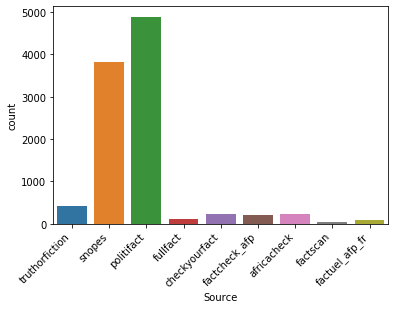

In [11]:
chart = sns.countplot(x = 'Source', data = df)
plt.setp(chart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

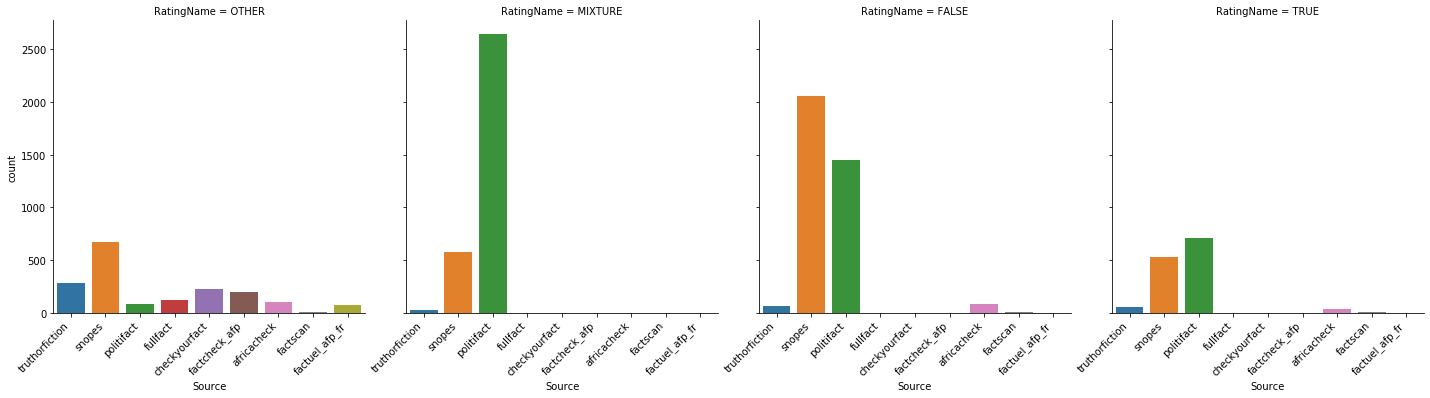

In [12]:
chart = sns.catplot(x = 'Source', col = 'RatingName', kind = 'count', data = df)
for ax in chart.axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

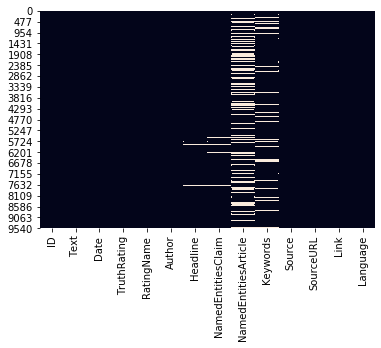

In [13]:
sns.heatmap(df.isnull(), cbar = False)
plt.show()

<div class="alert alert-block alert-info" align="center">
    <h1>
        Mapping ratings
    </h1>
</div>

In [14]:
class NormalizedRatings(Enum):
    FALSE = 1
    MIXTURE = 2
    TRUE = 3
    OTHER = -1

_normalization_dictionary = {  # type: Dict[str, Dict[str,NormalizedRatings]]
    "politifact": {  # type: Dict[str,NormalizedRatings]
        'incorrect': NormalizedRatings.FALSE,
        'pants-fire': NormalizedRatings.FALSE,
        'pants on fire': NormalizedRatings.FALSE,
        'pants on fire!': NormalizedRatings.FALSE,
        'false': NormalizedRatings.FALSE,
        'mostly correct': NormalizedRatings.MIXTURE,
        'mostly false': NormalizedRatings.MIXTURE,
        'barely true': NormalizedRatings.MIXTURE,
        'half true': NormalizedRatings.MIXTURE,
        'half-true': NormalizedRatings.MIXTURE,
        'mostly true': NormalizedRatings.MIXTURE,
        'true': NormalizedRatings.TRUE,
        'correct': NormalizedRatings.TRUE
    },
    "snopes": {  # type: Dict[str,NormalizedRatings]
        'false': NormalizedRatings.FALSE,
        'legend': NormalizedRatings.FALSE,
        'mixture': NormalizedRatings.MIXTURE,
        'mixture:': NormalizedRatings.MIXTURE,
        'true': NormalizedRatings.TRUE,
        'mostly false': NormalizedRatings.MIXTURE,
        'mostly true': NormalizedRatings.MIXTURE,
        'partly true': NormalizedRatings.MIXTURE,
        'MIXTURE OF TRUE AND FALSE INFORMATION': NormalizedRatings.MIXTURE,
        'MIXTURE OF TRUE AND FALSE INFORMATION:': NormalizedRatings.MIXTURE,
        'MIXTURE OF ACCURATE AND  INACCURATE INFORMATION': NormalizedRatings.MIXTURE
    },
    "africacheck": {  # type: Dict[str,NormalizedRatings]
        'incorrect': NormalizedRatings.FALSE,
        'mostly-correct': NormalizedRatings.MIXTURE,
        'correct': NormalizedRatings.TRUE
    },
    "factscan": {  # type: Dict[str,NormalizedRatings]
        'false': NormalizedRatings.FALSE,
        'true': NormalizedRatings.TRUE,
        'Misleading': NormalizedRatings.OTHER
    },
    "truthorfiction": {  # type: Dict[str,NormalizedRatings]
        'fiction': NormalizedRatings.FALSE,
        'truth': NormalizedRatings.TRUE,
        'truth & fiction': NormalizedRatings.MIXTURE,
        'mostly fiction': NormalizedRatings.MIXTURE,
        'truth & misleading': NormalizedRatings.MIXTURE,
        'mostly truth': NormalizedRatings.MIXTURE
    },
    "checkyourfact": {  # type: Dict[str,NormalizedRatings]
        'False': NormalizedRatings.FALSE,
        'True': NormalizedRatings.TRUE,
        'Mostly True': NormalizedRatings.MIXTURE,
        'true/false': NormalizedRatings.MIXTURE,
        'truth & misleading': NormalizedRatings.MIXTURE,
        'mostly truth': NormalizedRatings.MIXTURE,
        'misleading': NormalizedRatings.MIXTURE
    },
    "factcheck_aap": {
        "True": NormalizedRatings.TRUE,
        "False": NormalizedRatings.FALSE,
        "Mostly True": NormalizedRatings.MIXTURE,
        "Mostly False": NormalizedRatings.MIXTURE,
        "Somewhat True": NormalizedRatings.MIXTURE,
        "Somewhat False": NormalizedRatings.MIXTURE
    },
    "factuel_afp_fr": {
        'Faux': NormalizedRatings.FALSE,
        'Totalement faux': NormalizedRatings.FALSE,
        'Démenti': NormalizedRatings.FALSE,
        "C'est une oeuvre de fiction": NormalizedRatings.FALSE,
        'Vrai': NormalizedRatings.TRUE,
        'Totalement Vrai': NormalizedRatings.TRUE,
        'Plutôt vrai': NormalizedRatings.MIXTURE,
        'Trompeur': NormalizedRatings.MIXTURE,
        'trompeur': NormalizedRatings.MIXTURE,
        'Plutôt faux': NormalizedRatings.MIXTURE,
        'Presque': NormalizedRatings.MIXTURE,
        'Mélangé': NormalizedRatings.MIXTURE,
        'Mélange': NormalizedRatings.MIXTURE,
        'Inexact': NormalizedRatings.MIXTURE,
        'Incertain': NormalizedRatings.MIXTURE,
        'Imprécis': NormalizedRatings.MIXTURE,
        'Exagéré': NormalizedRatings.MIXTURE,
        'Douteux': NormalizedRatings.MIXTURE,
    },
    "factcheck_afp": {
        'False': NormalizedRatings.FALSE,
        'Fake': NormalizedRatings.FALSE,
        'Mixed': NormalizedRatings.MIXTURE,
        'Hoax': NormalizedRatings.FALSE,
        'Falso': NormalizedRatings.FALSE,
        'APRIL FOOL': NormalizedRatings.FALSE
    },
    "fullfact": {
        'Correct': NormalizedRatings.TRUE,
        'Incorrect': NormalizedRatings.FALSE,
        'Not quite': NormalizedRatings.MIXTURE
    }
}

def _standardize_name(original_name: str):
    return original_name.strip().lower().replace("!", "").replace(":", "").replace("-", " ")

def normalize(source_name, original_name) -> NormalizedRatings:
    '''
    Generate a normalized rating from the original ratings on each respective site
    :param original_name:
    :return normalized_rating: NormalizedRating
    '''
    try:
        source = _normalization_dictionary[source_name]
        normalized_value = source[_standardize_name(original_name)]
    except KeyError:
        normalized_value = NormalizedRatings.OTHER
    return normalized_value

<div class="alert alert-block alert-info" align="center">
    <h1>
        Pre-processing
    </h1>
</div>

## Copie du data frame

In [15]:
df2 = df.copy()

## Removing columns that contain NaN

In [16]:
df2 = df2.drop(['Headline', 'NamedEntitiesClaim', 'NamedEntitiesArticle', 'Keywords'], axis=1)

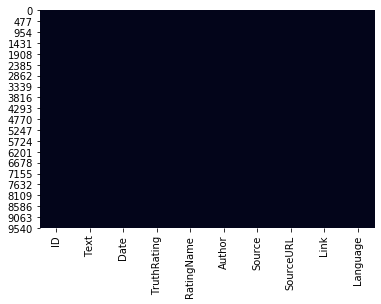

In [17]:
sns.heatmap(df2.isnull(), cbar = False)
plt.show()